In [185]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For text vectorization (same approach as your AI model):
import tensorflow as tf
from tensorflow.keras import layers

# For OLS
import statsmodels.api as sm

# For splitting data & evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# For the scatter plot
from sklearn.manifold import TSNE

In [186]:
OUTPUT_DIR = "../AI-CPS/code/learningBase_ols/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [187]:
df = pd.read_csv("../AI-CPS/data/joint_data_collection.csv")
print("Data sample:")
print(df.head())

Data sample:
                                               tweet  sarcastic
0  The only thing I got from college is a caffein...          1
1  I love it when professors draw a big question ...          1
2  Remember the hundred emails from companies whe...          1
3  Today my pop-pop told me I was not “forced” to...          1
4  @VolphanCarol @littlewhitty @mysticalmanatee I...          1


In [188]:
tweets = df["tweet"].astype(str).values
labels = df["sarcastic"].astype(int).values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    tweets, labels, test_size=0.2, random_state=42
)

In [189]:
max_tokens = 1000
sequence_length = 50

vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=sequence_length
)

vectorizer.adapt(X_train_text)

# Convert text to integer sequences
X_train_seq = vectorizer(X_train_text)
X_test_seq = vectorizer(X_test_text)

# Convert from TensorFlow Tensors to NumPy arrays
X_train_seq_np = np.array(X_train_seq)
X_test_seq_np = np.array(X_test_seq)

In [190]:
X_train_ols = sm.add_constant(X_train_seq_np)
X_test_ols = sm.add_constant(X_test_seq_np, has_constant="add")

ols_model = sm.OLS(y_train, X_train_ols)
results = ols_model.fit()

print("\nOLS Model Summary:")
print(results.summary())


OLS Model Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.345
Date:                Wed, 29 Jan 2025   Prob (F-statistic):             0.0543
Time:                        14:35:44   Log-Likelihood:                -1545.2
No. Observations:                2773   AIC:                             3192.
Df Residuals:                    2722   BIC:                             3495.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2239      0.017

In [191]:
y_pred_continuous = results.predict(X_test_ols)  # This is a continuous value
# Convert to binary by thresholding at 0.5
y_pred_binary = (y_pred_continuous >= 0.5).astype(int)

# Classification metrics
cm = confusion_matrix(y_test, y_pred_binary)
report = classification_report(y_test, y_pred_binary, digits=4)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


Confusion Matrix:
 [[495   0]
 [199   0]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7133    1.0000    0.8326       495
           1     0.0000    0.0000    0.0000       199

    accuracy                         0.7133       694
   macro avg     0.3566    0.5000    0.4163       694
weighted avg     0.5087    0.7133    0.5939       694



/home/tomen/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tomen/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tomen/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [192]:
ols_model_path = os.path.join(OUTPUT_DIR, "currentOlsSoluGon.pickle")
results.save(ols_model_path)


In [193]:
metrics_txt_path = os.path.join(OUTPUT_DIR, "ols_final_metrics.txt")
with open(metrics_txt_path, "w") as f:
    f.write("OLS on Sarcasm Classification\n")
    f.write("Using threshold at 0.5\n\n")
    f.write("Confusion Matrix:\n")
    f.write(str(cm) + "\n\n")
    f.write("Classification Report:\n")
    f.write(report + "\n")

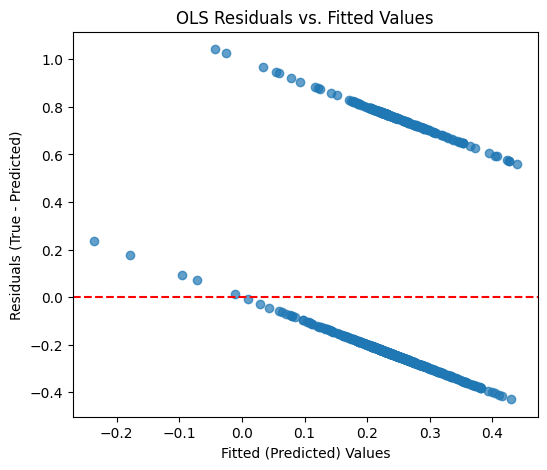

In [194]:
residuals = y_test - y_pred_continuous
plt.figure(figsize=(6,5))
plt.scatter(y_pred_continuous, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted (Predicted) Values")
plt.ylabel("Residuals (True - Predicted)")
plt.title("OLS Residuals vs. Fitted Values")
residual_plot_path = os.path.join(OUTPUT_DIR, "ols_residuals_vs_fitted.png")
plt.savefig(residual_plot_path)
plt.show()

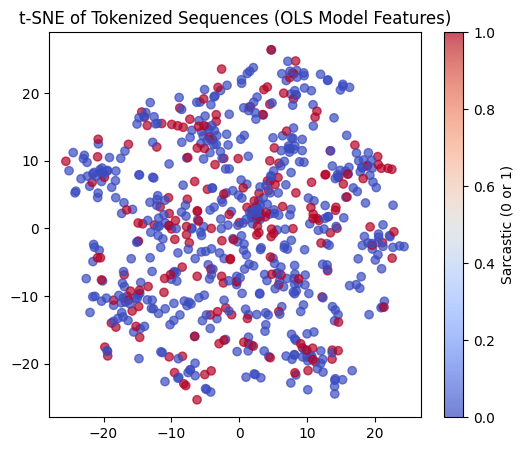

In [196]:
tsne = TSNE(n_components=2, random_state=42)
X_test_2d = tsne.fit_transform(X_test_seq_np)

plt.figure(figsize=(6,5))
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Sarcastic (0 or 1)")
plt.title("t-SNE of Tokenized Sequences (OLS Model Features)")
tsne_plot_path = os.path.join(OUTPUT_DIR, "ols_tsne_scatter.png")
plt.savefig(tsne_plot_path)
plt.show()

In [197]:
!ls

 data				    OLS_model			      'week 2'
 dataset02_testing.csv		    requirements.txt		      'week 3'
 dataset02_training.csv		    sarcasm_model.h5		      'week 4'
'Fahrzeugübersicht 2024 (2).xlsx'   scatter_with_regression_line.pdf  'week 5'
 housing_data.csv		    tf_model_1.h5		      'week 6'
 intro_pytorch.ipynb		    tf_model_1.keras		      'week 7'
 learningBase			    UE_04_App2_BoxPlot.pdf	      'week 8'
 ml2_python3_11			    Untitled.ipynb		      'week 9'


In [199]:
!mv tf_model_1.h5 ../AI-CPS/code/learningBase/